### Introduction

The purpose of this analysis is to gain some quick insights into the data and more importantly, test some ideas that can be implemented in the web dashboard.

Specifically, the aim is to design an effective algorithm that determines the optimal path for learning towards a data analyst/scientist career.


### Data Loading
The data are retrieved from the MongoDB collection in the ETL pipeline previously, in JSON format.

In [1]:
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from skills_crawling.settings import MONGO_URI

import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections.abc import Iterable
from collections import Counter
from itertools import combinations_with_replacement, combinations, permutations, product

mongo_uri = MONGO_URI
mongo_db = 'data-analysis'
mongo_collection = 'skills-crawling'

client = pymongo.MongoClient(mongo_uri)
db = client[mongo_db]
collection = db[mongo_collection]

In [2]:
documents = list(collection.find({"category": "Data Analyst"}))
count = len(documents)

print(f"Total number of documents retrieved: {count}")

Total number of documents retrieved: 919


### Data Exploration
Firstly, the histogram of the number of skills required by the job listings in each skill category (Programming, BI Software, Database Platform, Cloud Technology) is plotted.

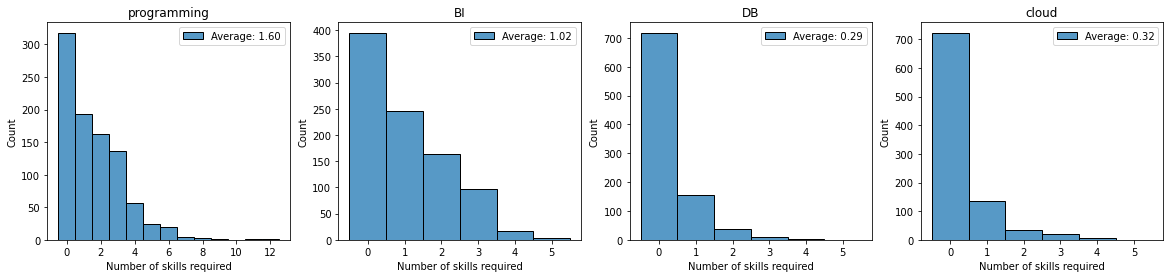

In [12]:
skill_dist = {
    "programming": [],
    "BI": [],
    "DB": [],
    "cloud": []
}

for doc in documents:
    for skill in skill_dist.keys():
        num_skills = 0
        if skill in doc:
            num_skills = len(doc[skill])
        skill_dist[skill].append(num_skills)

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)
for idx, skill in enumerate(skill_dist.keys()):
    ax = axes[idx]
    sns.histplot(skill_dist[skill], ax=ax, discrete=True)
    avg = sum(skill_dist[skill])/len(skill_dist[skill])
    ax.legend([f"Average: {avg:.2f}"])
    ax.set_title(skill)
    ax.set_xlabel("Number of skills required")


Then, the count of appearance of each skill in each category, along side with education requirements, are plotted.

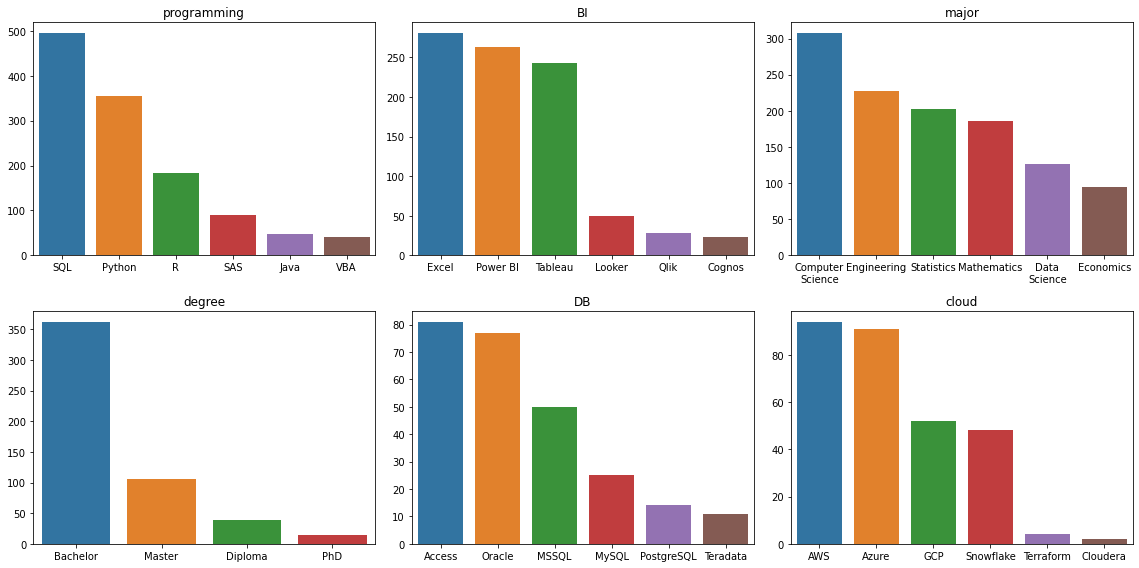

In [4]:
skill_set = {
    "programming": [],
    "BI": [],
    "major": [],
    "degree": [],
    "DB": [],
    "cloud": []
}

for item in documents:
    for key in skill_set.keys():
        if key not in item:
            continue
        skill_set[key].extend(item[key])
        
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(16, 8)
for idx, key in enumerate(skill_set.keys()):
    ax = axes[idx // 3][idx % 3]
    ax.set_title(key)
    c = dict(Counter(skill_set[key]).most_common(6))
    _x = list(map(lambda key: key.replace(" ", "\n") if len(key) > 8 else key, c.keys()))
    _y = list(c.values())
    sns.barplot(x=_x, y=_y, ax=ax)
fig.tight_layout()
plt.show()
    

### Analysis of Skills Dependency
While many skills in the above bar plots are useful as a data analyst or data scientist, some skills are more related to each other than the rest.

For example, analysts that most work with Access database are much less likely to need SQL, despite being the most in-demand skills. 

In view of this, the following analysis focus on the conditional probability of one skill to be required given any other skills.

In [5]:
def is_iterable(e):
    return isinstance(e, Iterable) and not isinstance(e, str)

def validate_filter(document: dict, filter: dict) -> bool:
    for key, val in filter.items():
        if key not in document:
            return False
        if is_iterable(val):
            for v in val:
                if v not in document[key]:
                    return False
        else:
            if val not in document[key]:
                return False
    return True

def count_documents_by_filter(documents: list, filter: dict) -> list:
    count = 0
    for doc in documents:
        valid = validate_filter(doc, filter)
        if valid:
            count += 1
    return count


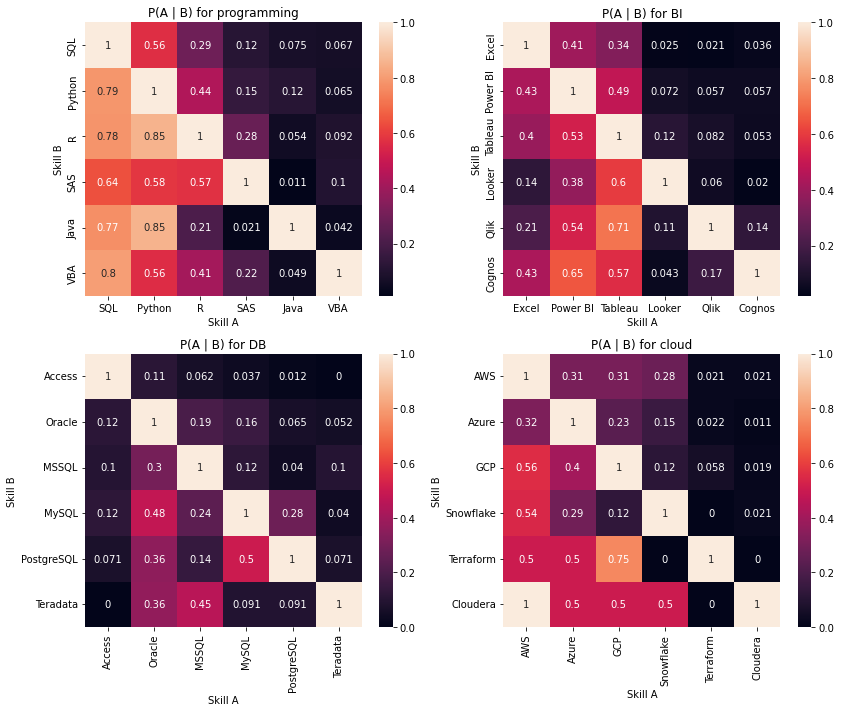

In [6]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
for idx, skill_cat in enumerate(skill_dist.keys()):
    ax = axes[idx // 2][idx % 2]
    c = dict(Counter(skill_set[skill_cat]).most_common(6)).keys()
    df = pd.DataFrame(columns=c, index=c)
    skill_pairs = combinations_with_replacement(c, 2)
    for pair in skill_pairs:
        A, B = pair
        N_A = count_documents_by_filter(documents, filter={skill_cat: A})
        N_B = count_documents_by_filter(documents, filter={skill_cat: B})
        N_AB = count_documents_by_filter(documents, filter={skill_cat: pair})
        df[B].loc[A] = N_AB/N_A
        df[A].loc[B] = N_AB/N_B
    sns.heatmap(df.astype(np.float32), ax=ax, annot=True)
    ax.set_title(f"P(A | B) for {skill_cat}")
    ax.set_xlabel("Skill A")
    ax.set_ylabel("Skill B")
fig.tight_layout()

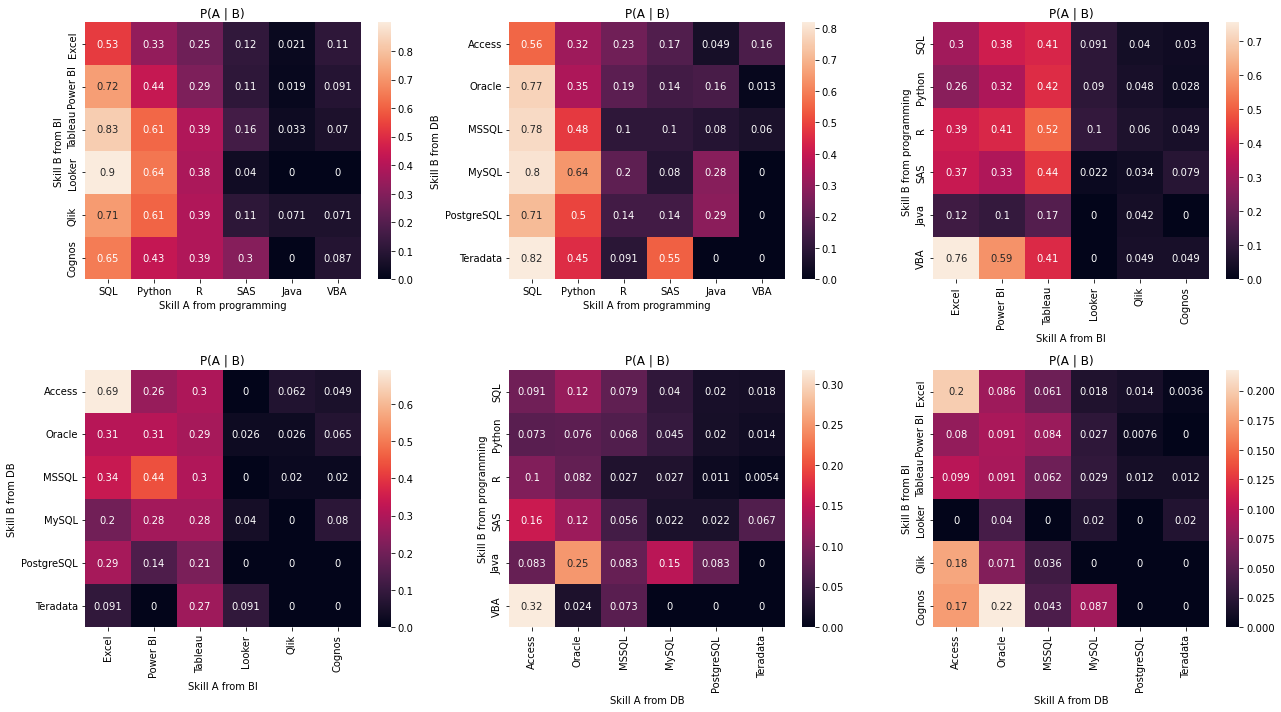

In [7]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(18, 10)
# cat_pairs = product(["programming", "BI", "DB"], ["programming", "BI", "DB"])
cat_pairs = combinations(["programming", "BI", "DB"], 2)
cat_pairs = permutations(["programming", "BI", "DB"], 2)
cat_pairs = [pair for pair in cat_pairs if pair[0] != pair[1]]
for idx, pair in enumerate(cat_pairs):
    ax = axes[idx // 3][idx % 3]
    catA, catB = pair
    kA = dict(Counter(skill_set[catA]).most_common(6)).keys()
    kB = dict(Counter(skill_set[catB]).most_common(6)).keys()
    skill_pairs = product(kA, kB)
    df = pd.DataFrame(columns=kA, index=kB)
    for pair in skill_pairs:
        A, B = pair
        N_A = count_documents_by_filter(documents, filter={catA: A})
        N_B = count_documents_by_filter(documents, filter={catB: B})
        N_AB = count_documents_by_filter(documents, filter={catA: A, catB: B})
        df[A].loc[B] = N_AB/N_B
    sns.heatmap(df.astype(np.float32), ax=ax, annot=True)
    ax.set_title(f"P(A | B)")
    ax.set_xlabel(f"Skill A from {catA}")
    ax.set_ylabel(f"Skill B from {catB}")
fig.tight_layout()
    

From the above plots, it is clear that there are some dependency among the skills. The naive approach of simply following the most in-demand skills might not be optimal.

For example, if you are looking for a job that requires SQL because you have expertise in that, it would be more effective to learn Oracle next instead of Access, even though Access has a slightly higher frequency from the data.

Because the final algorithm will be implemented in JavaScript, the full algorithm will not be implemented and tested in this notebook. 

The web-based dashboard can be found in [here](https://data-skills-dashboard.netlify.app/).